# Aprendizaje Automático - Proyecto Final

**Grupo 2:** Carlos Montiel, Juan Sánches y Alejandro Duque

**Tema:** Predicción del rating promedio de una película dada una cadena de tags que la describan

# Introducción

Dentro del mundo cinematográfico es sumamente difícil saber cómo va a ser la recepción a una película lanzada basándose en un texto crítico, varias publicaciones o incluso usuarios críticos hacen uso de textos extensos, pero es difícil lograr interpretar el rating promedio que esta película va a tener según la semántica usada. Nuestro modelo trata de resolver este problema usando como experiencia (E)  la base de datos MovieLens, una base de datos que contiene 27 millones de ratings aplicado a 58 mil películas por 280 mil usuarios. Como ya se dijo previamente la tarea en cuestión (T) es lograr predecir el rating medio de la película según los tags fundamentales obtenidos del texto. Finalmente, el desempeño (P) de este modelo se basa en la cercanía de la predicción a la media de la clasificación real.

# Desarrollo

## Installs

In [ ]:
! pip3 install scikeras
! pip3 install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 3.9 MB/s 


## Imports

In [ ]:
# Remove warning from cells
import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import gdown


# Basic Imports
import pandas as pd
import numpy as np


# Preprocesamiento
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

# Modelos
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_addons.metrics import RSquare
import keras
from keras.metrics import MeanSquaredError, RootMeanSquaredError
from keras.utils.generic_utils import get_custom_objects
from scikeras.wrappers import KerasRegressor
from sklearn.pipeline import Pipeline,  make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

# Seleccion de modelo
from sklearn.model_selection import RepeatedKFold, KFold, GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import train_test_split

from scipy.stats import wilcoxon

# Exportacion de modelo
import joblib

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Raw Datasets

Se utilizará el dataset: https://grouplens.org/datasets/movielens/latest/

Esta base de datos contiene tags y ratings que 280 mil usuarios asignaron a 58 mil películas. Los datos se organizan de forma relacional estructurada, dentro de archivos csv

In [ ]:
dataset = "ml-latest"

### Descargar datasets

In [ ]:
dataset_url = f"https://files.grouplens.org/datasets/movielens/{dataset}.zip"
os.system(f"wget  {dataset_url}")
os.system(f"unzip  {dataset}.zip")

256

### Lectura de datasets

In [ ]:
def read_file(file_name):
    return pd.read_csv(f'./{dataset}/{file_name}.csv')

In [ ]:
movies = read_file('movies')
ratings = read_file('ratings')
tags = read_file('tags')

El archivo movies.csv contiene la tabla de información de cada película. La llave primaria es el movie Id

In [ ]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed)
58094,193878,Les tribulations d'une caissière (2011),Comedy
58095,193880,Her Name Was Mumu (2016),Drama
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi


El archivo rating.csv corresponde a una tabla relacional, que contiene ratings de películas asignados por usuarios. Las llaves foráneas son userId y movieId

In [ ]:
ratings

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264
...,...,...,...,...
27753439,283228,8542,4.5,1379882795
27753440,283228,8712,4.5,1379882751
27753441,283228,34405,4.5,1379882889
27753442,283228,44761,4.5,1354159524


El archivo tags.csv corresponde a una tabla relacional, que contiene tags de películas asignados por usuarios. Las llaves foráneas son userId y movieId

In [ ]:
tags

,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195
...,...,...,...,...
1108992,283206,73017,fun,1264379059
1108993,283206,73017,homoerotic subtext,1264379058
1108994,283206,73017,pacing,1264379058
1108995,283206,73017,plot,1264379058


## Preprocesamiento

### Features

La entrada para el modelo de machine learning será la representación en vector de una cadena de tags que represente la percepción de la audiencia en relación a una película. Esto quiere decir que cada película supondrá una única instancia en nuestro dataset final.

Es importante notar que la cantidad de tags que tiene una película depende en gran medida de su popularidad, por lo que hay películas con muy pocos tags. Se decidió entonces conservar únicamente aquellas películas con al menos 10 tags. A continuación se combinan los tags que todos los usuarios han dado sobre una misma película en una única cadena de texto.


In [ ]:
min_tags = 10
data_tags = tags.drop(['userId', 'timestamp'], axis = 1) \
                .groupby(['movieId']) \
                .filter(lambda group:  len(group)>=min_tags) \
                .groupby(['movieId']) \
                .aggregate(lambda group: ' '.join(str(tag) for tag in group)) \
                .rename(columns = {'tag': 'tags'})

Como preprocesamiento adicional, se decide:
* Pasar todo el texto a lowercase
* Eliminar todo signo de puntuación
* Eliminar stop words

In [ ]:
def preprocess_text(text):
    text = text.lower()
    # Eliminar signos de puntuacion
    text = text.translate(str.maketrans('', '', string.punctuation))
    tags = []
    for tag in text.split(' '):
        # Omitir stop words
        if len(tag)>2 and tag not in stopwords.words('english'):
            tags.append(tag)
    return ' '.join(tags)

data_tags['tags'] = data_tags['tags'].apply(preprocess_text)
data_tags

,tags
movieId,
1,animated buddy movie cartoon cgi comedy comput...
2,fantasy adapted frombook animals bad cgi based...
3,moldy old ann margaret burgess meredith daryl ...
4,characters girl movie characters chick flick b...
5,steve martin steve martin pregnancy remake agi...
...,...
193149,amaia salamanca bet brotherbrother relation br...
193261,1930s actress anna mouglalis fear french horro...
193293,chinese martial arts comedic goofy jiang shi j...


### Word embedding

Los modelos de machine learning necesitan trabajar sobre entradas numéricas, por esta razón es necesario transformar la cadena de tags en una representación de vector numérico. 

Existen varias formas de hacer esto usando modelos de NLP preentrenado. En este caso de usará un modelo de nnlm (Neural Network Language Model) que fue preentrenado sobre el English Google News corpus. El modelo está disponible en tensorflowhub.


In [ ]:
dim_embedding = 50
def create_nnlm_model():
  hub_url = "https://tfhub.dev/google/nnlm-en-dim50/2"
  embed_layer = hub.KerasLayer(hub_url, input_shape=[], dtype=tf.string, trainable=False)
  model_nnlm = keras.Sequential()
  model_nnlm.add(embed_layer)
  return model_nnlm

In [ ]:
model_nnlm = create_nnlm_model()
model_nnlm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 50)                48190600  
                                                                 
Total params: 48,190,600
Trainable params: 0
Non-trainable params: 48,190,600
_________________________________________________________________


In [ ]:
data_embeddings = model_nnlm.predict(data_tags, verbose=False)
data_embeddings.shape

(14656, 50)

Se formatean los embeddings en un dataframe con índice adecuado, y nombres de columnas

In [ ]:
data_embeddings = pd.DataFrame(data_embeddings)
data_embeddings.columns = [f'Feature {i}' for i in range(dim_embedding)]
data_embeddings.index = data_tags.index
data_embeddings

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 40,Feature 41,Feature 42,Feature 43,Feature 44,Feature 45,Feature 46,Feature 47,Feature 48,Feature 49
movieId,,,,,,,,,,,,,,,,,,,,,
1,2.013787,-2.873946,-2.503675,-0.382776,0.398324,0.087414,0.024961,-3.769047,-3.772265,-0.053829,...,-0.066591,0.419805,0.153001,-0.195479,-2.919035,-0.034676,-0.786196,-0.924649,4.244995,3.084903
2,1.688889,-0.614420,-1.419735,-1.228704,-0.414678,-0.294612,-0.081384,-0.472801,-2.389474,-0.305474,...,0.112020,-0.840519,0.495918,0.124137,-0.774624,1.069695,-0.746827,-0.211570,2.374461,1.131040
3,1.189798,-0.597724,-0.556180,-0.473029,0.371192,-0.208536,0.041325,0.077874,-0.220890,-0.025645,...,0.300512,-0.125711,-0.145979,-0.400362,-0.500727,0.380398,-0.518261,-0.217905,0.593139,0.491987
4,0.053938,-0.366784,-0.412073,-0.205644,-0.156985,0.110605,-0.162939,-0.870266,-0.305826,-0.394059,...,-0.096562,-0.044298,-0.231862,-0.354104,-0.322362,0.056779,-0.174689,-0.322855,0.735939,0.050495
5,0.366346,-0.822644,-0.504521,-0.632580,-0.124251,-0.630122,0.024234,-0.520865,-0.546344,0.033577,...,0.541956,-0.326051,-0.112760,-0.403732,-0.401808,0.230172,-0.383597,-0.074782,1.114532,0.304644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193149,0.556910,-0.422299,-0.345232,-0.421511,-0.071314,-0.040002,-0.273698,-0.634549,-0.511282,-0.236152,...,0.697222,0.232248,-0.155166,-0.065983,0.039399,-0.133581,-0.126984,0.134557,0.626172,0.032054
193261,0.250624,-0.489365,-0.386644,-0.329540,-0.032275,-0.001654,-0.265961,-0.589779,-0.377170,-0.169100,...,0.192871,-0.050324,0.255248,-0.467842,0.073673,0.049168,0.088859,0.085931,0.603636,0.151208
193293,0.412071,-0.398303,-0.148556,-0.114933,0.045140,0.091507,-0.336450,-0.250882,-0.516550,0.008300,...,0.380562,-0.132912,-0.279821,-0.508315,-0.251528,-0.102242,-0.064701,0.394265,0.472742,0.009547


Se genera la matriz de covarianza de las features obtenidas

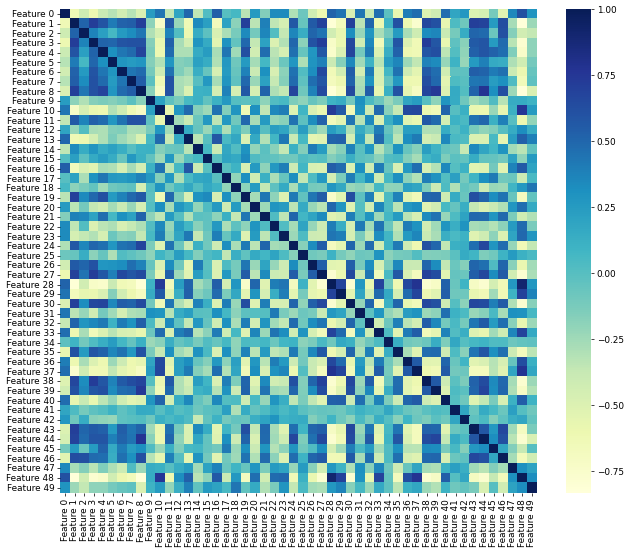

In [ ]:
fig, ax = plt.subplots(figsize=(12,10), dpi=64) 
sns.heatmap(data_embeddings.corr(), cmap="YlGnBu", annot=False, ax=ax)

### Output

La salida del modelo será la predicción del rating medio. Para obtener el rating medio de una película se agrupan todos los ratings dados a una misma película y se obtiene su promedio.

In [ ]:
data_ratings = ratings.drop(['userId', 'timestamp'], axis = 1) \
                    .groupby('movieId') \
                    .mean() \
                    .rename(columns = {'rating': 'mean rating'})
data_ratings

,mean rating
movieId,
1,3.886649
2,3.246583
3,3.173981
4,2.874540
5,3.077291
...,...
193876,3.000000
193878,2.000000
193880,2.000000


### Combinar Features y Output

Se agrupan las features y el output en un solo dataframe haciendo un inner join de ambas tablas. Al hacer esto se logra empatar justamente el word embedding de una película con el rating medio que le corresponde.

In [ ]:
data = pd.concat([data_tags, data_embeddings, data_ratings], join='inner', axis=1)
data

,tags,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,...,Feature 41,Feature 42,Feature 43,Feature 44,Feature 45,Feature 46,Feature 47,Feature 48,Feature 49,mean rating
movieId,,,,,,,,,,,,,,,,,,,,,
1,animated buddy movie cartoon cgi comedy comput...,2.013787,-2.873946,-2.503675,-0.382776,0.398324,0.087414,0.024961,-3.769047,-3.772265,...,0.419805,0.153001,-0.195479,-2.919035,-0.034676,-0.786196,-0.924649,4.244995,3.084903,3.886649
2,fantasy adapted frombook animals bad cgi based...,1.688889,-0.614420,-1.419735,-1.228704,-0.414678,-0.294612,-0.081384,-0.472801,-2.389474,...,-0.840519,0.495918,0.124137,-0.774624,1.069695,-0.746827,-0.211570,2.374461,1.131040,3.246583
3,moldy old ann margaret burgess meredith daryl ...,1.189798,-0.597724,-0.556180,-0.473029,0.371192,-0.208536,0.041325,0.077874,-0.220890,...,-0.125711,-0.145979,-0.400362,-0.500727,0.380398,-0.518261,-0.217905,0.593139,0.491987,3.173981
4,characters girl movie characters chick flick b...,0.053938,-0.366784,-0.412073,-0.205644,-0.156985,0.110605,-0.162939,-0.870266,-0.305826,...,-0.044298,-0.231862,-0.354104,-0.322362,0.056779,-0.174689,-0.322855,0.735939,0.050495,2.874540
5,steve martin steve martin pregnancy remake agi...,0.366346,-0.822644,-0.504521,-0.632580,-0.124251,-0.630122,0.024234,-0.520865,-0.546344,...,-0.326051,-0.112760,-0.403732,-0.401808,0.230172,-0.383597,-0.074782,1.114532,0.304644,3.077291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193149,amaia salamanca bet brotherbrother relation br...,0.556910,-0.422299,-0.345232,-0.421511,-0.071314,-0.040002,-0.273698,-0.634549,-0.511282,...,0.232248,-0.155166,-0.065983,0.039399,-0.133581,-0.126984,0.134557,0.626172,0.032054,3.000000
193261,1930s actress anna mouglalis fear french horro...,0.250624,-0.489365,-0.386644,-0.329540,-0.032275,-0.001654,-0.265961,-0.589779,-0.377170,...,-0.050324,0.255248,-0.467842,0.073673,0.049168,0.088859,0.085931,0.603636,0.151208,3.250000
193293,chinese martial arts comedic goofy jiang shi j...,0.412071,-0.398303,-0.148556,-0.114933,0.045140,0.091507,-0.336450,-0.250882,-0.516550,...,-0.132912,-0.279821,-0.508315,-0.251528,-0.102242,-0.064701,0.394265,0.472742,0.009547,3.500000


### Guardar Dataset Preprocesado

Se  guardan los datos preprocesados en un archivo csv, para no tener que volver a ejecutar el preprocesamiento cada vez que se abra el google colab

In [ ]:
data.to_csv(f'{dataset}.csv')

## Cargar Dataset Preprocesado

In [ ]:
dataset = "ml-latest"
drive_url = "https://drive.google.com/uc?id=17J1YXv32hglCR9P_xE9g7mDTIEE6AHzr"
gdown.download(drive_url, f'{dataset}.csv')

Downloading...
From: https://drive.google.com/uc?id=17J1YXv32hglCR9P_xE9g7mDTIEE6AHzr
To: /content/ml-latest.csv
100%|██████████| 19.8M/19.8M [00:00<00:00, 143MB/s]


'ml-latest.csv'

In [ ]:
data = pd.read_csv(f'{dataset}.csv')
X = data.drop(['movieId', 'tags', 'mean rating'], axis=1)
y = data['mean rating'].to_frame()
X.shape

(14572, 50)

## Visualización del Dataset

Utilizando TSNE se realiza una reducción de dimensionalidad de las features hacia un espacio de dos dimensiones. Se visualiza el dataset en este nuevo espacio, utilizando una escala de color para indicar el rating correspondiente a cada instancia.

In [ ]:
dim_reduction = make_pipeline(MinMaxScaler(), TSNE(n_components=2))
num_points = 1500
X_sampled = X.sample(n=num_points, random_state=123)
Z = dim_reduction.fit_transform(X_sampled)
dim1 = Z[:,0]
dim2 = Z[:,1]

y_sampled = y.sample(n=num_points, random_state=123)
colors = np.array(y_sampled)

[]

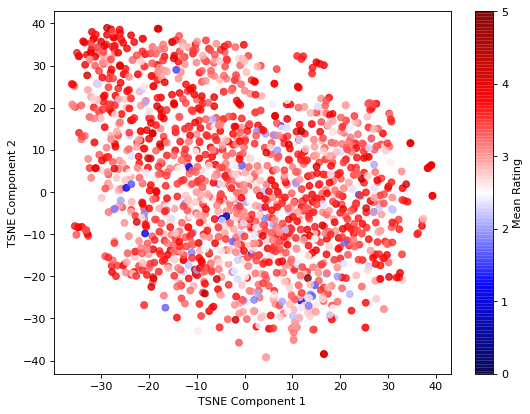

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(dim1, dim2, c=colors, vmin=0, vmax=5, cmap='seismic', alpha=0.8)
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.colorbar().set_label("Mean Rating")
plt.plot()

## Entrenamiento y evaluación de modelos

### Baseline

Como baseline para saber qué tan bien se desempeña un modelo se podría usar el error cuadrático medio que se obtiene al predecir a cada película que su rating promedio es exactamente igual al promedio del rating promedio sobre todas las películas.

In [ ]:
mean_squared_error(y, [y.mean()]*len(y))

0.2808388812925702

### Regresión Lineal Regularizada: ElasticNet

#### Definición Modelo

Se crea una funcion que genere un  Pipeline que lleve a cabo las transformaciones de preprocesamiento deseadas: Generacion de Features Polinomiales y Normalizacion. E igualmente que contenga el modelo de Regresion Lineal Regularizado con ElasticNet.

In [ ]:
def create_linearRegPipeline():
  return Pipeline([('polyfeats', PolynomialFeatures()),
                    ('minmax', MinMaxScaler()),
                    ('elasticnet', ElasticNet())])

#### Definición GridSearch

Se crea un diccionario de los hyperparametros a optimizar dentro de el modelo regularizado que son: grado de las caracteristicas polinomiales generadas, hyperparametro alpha, y proporcion l1:l2. También se define el gridsearch para realizar la búsqueda de hyperparámetros.

In [ ]:
degreeFeats=[1, 2]
alpharange=[0.01, 0.1, 1]
l1range=[0.25, 0.5, 0.75]
params_LR=dict(polyfeats__degree=degreeFeats,
                elasticnet__alpha=alpharange,
                elasticnet__l1_ratio=l1range)

pipe_lr = create_linearRegPipeline()
inner_kfold = KFold(n_splits=3, shuffle=True, random_state=12345)
grid_search_LR = GridSearchCV(pipe_lr, params_LR,  scoring='neg_mean_squared_error', cv=inner_kfold, refit=True)
grid_search_LR

GridSearchCV(cv=KFold(n_splits=3, random_state=12345, shuffle=True),
             estimator=Pipeline(steps=[('polyfeats', PolynomialFeatures()),
                                       ('minmax', MinMaxScaler()),
                                       ('elasticnet', ElasticNet())]),
             param_grid={'elasticnet__alpha': [0.01, 0.1, 1],
                         'elasticnet__l1_ratio': [0.25, 0.5, 0.75],
                         'polyfeats__degree': [1, 2]},
             scoring='neg_mean_squared_error')

#### Ejecución Cross Validation

In [ ]:
outer_kfold = RepeatedKFold(n_splits=6, n_repeats=2, random_state=12345)
cv_results_LR = - cross_val_score(grid_search_LR, X=X, y=y, cv=outer_kfold)
cv_results_LR

array([0.24446379, 0.26571127, 0.27475148, 0.26005614, 0.23737063,
       0.27355744, 0.25655382, 0.27165377, 0.25634366, 0.26014087,
       0.26311904, 0.24833001])

#### Modelo Final

Se hallan los mejores hyperaparametros y se entrena un último modelo sobre todo el dataset

In [ ]:
grid_search_LR.fit(X, y)
grid_search_LR.best_params_

{'elasticnet__alpha': 0.01,
 'elasticnet__l1_ratio': 0.25,
 'polyfeats__degree': 1}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

best_degree = grid_search_LR.best_params_['polyfeats__degree']
best_alpha = grid_search_LR.best_params_['elasticnet__alpha']
best_l1_ration = grid_search_LR.best_params_['elasticnet__l1_ratio']

best_pipeline_LR = Pipeline([('polyfeats', PolynomialFeatures(degree=best_degree)),
                             ('minmax', MinMaxScaler()),
                             ('elasticnet', ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ration))])
best_pipeline_LR = best_pipeline_LR.fit(X_train, y_train)

##### Metricas Modelo Final

In [ ]:
y_train_pred = best_pipeline_LR.predict(X_train)
y_test_pred = best_pipeline_LR.predict(X_test)

metrics = {
    'loss': best_pipeline_LR.score(X_train, y_train),
    'mean_squared_error': mean_squared_error(y_train, y_train_pred),
    'root_mean_squared_error': mean_squared_error(y_train, y_train_pred, squared=False),
    'r_square':  r2_score(y_train, y_train_pred),
    'val_loss': best_pipeline_LR.score(X_test, y_test),
    'val_mean_squared_error': mean_squared_error(y_test, y_test_pred),
    'val_root_mean_squared_error': mean_squared_error(y_test, y_test_pred, squared=False),
    'val_r_square':  r2_score(y_test, y_test_pred)
}
metrics = pd.Series(metrics)
metrics

loss                           0.074405
mean_squared_error             0.260901
root_mean_squared_error        0.510785
r_square                       0.074405
val_loss                       0.068529
val_mean_squared_error         0.252901
val_root_mean_squared_error    0.502892
val_r_square                   0.068529
dtype: float64

##### Exportar Modelo Final

Se guarda el modelo entrenado dentro de un archivo: 

In [ ]:
joblib.dump(best_pipeline_LR, 'best_pipeline_LR.joblib')

['best_pipeline_LR.joblib']

#### Learning Curve

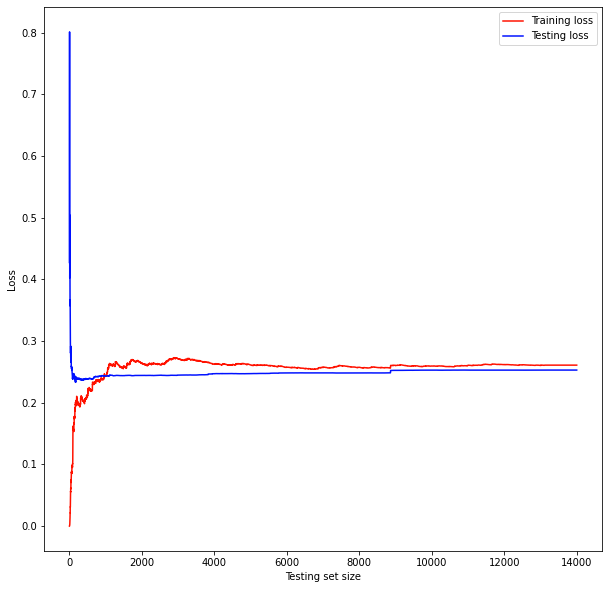

In [ ]:
tloss=[]
vloss=[]
xsize=[]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
for i in range(14000):
  xtrain=X_train[:i+1]
  ytrain=y_train[:i+1]
  xsize.append(i)
  temp_model=best_pipeline_LR.fit(xtrain,ytrain)
  ytrain_pred=temp_model.predict(xtrain) 
  tloss.append(mean_squared_error(ytrain,ytrain_pred))
  ytest_pred=temp_model.predict(X_test)
  vloss.append(mean_squared_error(y_test,ytest_pred))

plt.subplots(1, figsize=(10,10))
plt.plot(xsize, tloss, color="#ff1100",  label="Training loss")
plt.plot(xsize, vloss, color="#0011ff", label="Testing loss")
plt.xlabel("Testing set size")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Red Neuronal

#### Definición Modelo

Se aprovecha de la flexibilidad de las redes neuronales para definir una función de activación propia llamada rating_activation. Esta activación permitirá mapear un número real al intervalo (0,5), que es justamente el intervalo de predicción para el rating medio.

Se escribe una función para crear una arquitectura de red que recibe como parámetro el número de capas ocultas, número de neuronas por capa oculta, y el factor de regularización. La red neuronal se optimizará en base a la métrica de error cuadrático medio, usando el método de descenso de gradiente adam.

In [ ]:
def rating_activation(X):
    return 5 * keras.backend.sigmoid(X)

def create_neural_network(hidden_layers, neurons, regularization):
    regularizer = keras.regularizers.L1L2(l1=regularization, l2=regularization)
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape = (50)))
    for layer in range(hidden_layers):
        model.add(keras.layers.Dense(units = neurons, activation='relu', kernel_regularizer=regularizer))
    model.add(keras.layers.Dense(units = 1, kernel_regularizer=regularizer))
    model.add(keras.layers.Activation(rating_activation))
    model.compile(optimizer='adam', loss='mean_squared_error', 
                  metrics=[MeanSquaredError(), RootMeanSquaredError(), RSquare()])
    return model

create_neural_network(2, 20, 0.1).summary() # Model example

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                1020      
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 1,461
Trainable params: 1,461
Non-trainable params: 0
_________________________________________________________________


#### Definición GridSearch

Se construye un pipeline en el que se aplicará de forma secuencial la normalización de los datos y entrenamiento del modelo. También se define un gridsearch que se encargará de realizar la búsqueda de hyperparámetros óptimos del pipeline.

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model_nn = KerasRegressor(model=create_neural_network, epochs=30, callbacks=[callback], verbose=False)
pipeline_nn = Pipeline([('scaler', MinMaxScaler()),
                        ('regressor', model_nn)])
params_nn = {
    "regressor__model__hidden_layers": [1, 2], 
    "regressor__model__neurons": [10, 20],
    "regressor__model__regularization": [0.01, 0.1],
    }

inner_kfold = KFold(n_splits=3, shuffle=True, random_state=12345)
grid_search_nn = GridSearchCV(pipeline_nn, params_nn, scoring='neg_mean_squared_error', cv=inner_kfold, refit=True)
grid_search_nn

GridSearchCV(cv=KFold(n_splits=3, random_state=12345, shuffle=True),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('regressor',
                                        KerasRegressor(callbacks=[<keras.callbacks.EarlyStopping object at 0x7fe129992c70>], epochs=30, model=<function create_neural_network at 0x7fe12987eca0>, verbose=False))]),
             param_grid={'regressor__model__hidden_layers': [1, 2],
                         'regressor__model__neurons': [10, 20],
                         'regressor__model__regularization': [0.01, 0.1]},
             scoring='neg_mean_squared_error')

#### Ejecución Cross Validation

Se ejecuta un repeated k fold cross validation para estimar el desempeño promedio del modelo. En cada iteración se lleva a cabo la búsqueda de hyperparámetros con el GridSearchCV definido arriba.

In [ ]:
outer_kfold = RepeatedKFold(n_splits=6, n_repeats=2, random_state=12345)
cv_results_nn = - cross_val_score(grid_search_nn, X=X, y=y, cv=outer_kfold)
cv_results_nn

array([0.2640282 , 0.29179135, 0.29671127, 0.28118333, 0.25794553,
       0.2937058 , 0.28152644, 0.29396346, 0.27707345, 0.2818235 ,
       0.28451037, 0.26679489])

#### Modelo Final

Ahora que se estimó el desempeño del modelo, se ejecuta una única gridsearch para determinar cuáles fueron los hyperparámetros de mejor desempeño.

In [ ]:
grid_search_nn.fit(X, y)
grid_search_nn.best_params_

{'regressor__model__hidden_layers': 2,
 'regressor__model__neurons': 20,
 'regressor__model__regularization': 0.1}

Se entrena un último modelo usando los mejores hyperparámetros sobre todo el dataset.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

best_model_nn = create_neural_network(* grid_search_nn.best_params_.values())
best_model_nn = KerasRegressor(best_model_nn, epochs=30, callbacks=[callback], verbose=False, fit__validation_data = (X_test, y_test))
best_pipeline_nn = Pipeline([('scaler', MinMaxScaler()),('regressor', best_model_nn)])
best_pipeline_nn = best_pipeline_nn.fit(X_train, y_train)

##### Metricas Modelo Final

Se presentan las métricas obtenidas y se plotean las curvas de aprendizaje del set de entrenamiento y de test.

In [ ]:
history = best_pipeline_nn['regressor'].model.history.history
metrics = pd.DataFrame(history).iloc[-1]
metrics

loss                           0.298793
mean_squared_error             0.281910
root_mean_squared_error        0.530952
r_square                      -0.000127
val_loss                       0.288330
val_mean_squared_error         0.271513
val_root_mean_squared_error    0.521069
val_r_square                  -0.000006
Name: 7, dtype: float64

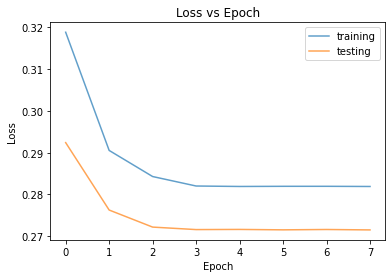

In [ ]:
def plot_history_loss(history_train_rmse, history_val_rmse):
  plt.plot(history_train_rmse, alpha=0.7)
  plt.plot(history_val_rmse, alpha=0.7)
  plt.title('Loss vs Epoch')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['training', 'testing'], loc='best')
  plt.show()

plot_history_loss(history['mean_squared_error'],  history['val_mean_squared_error'])

##### Exportar Modelo Final

Por último se guarda el modelo entrenado (arquitectura y pesos).

In [ ]:
best_pipeline_nn['regressor'].fit__validation_data = None # Se elimina la validation_data para guardar
best_pipeline_nn['regressor'].model.save('best_model_nn.h5')
best_pipeline_nn['regressor'].model = None
joblib.dump(best_pipeline_nn, 'best_pipeline_nn.joblib')

['best_pipeline_nn.joblib']

## Comparación de modelos

Se calcula la media de los resultados obtenidos en el repeated cross validation y se halla que en promedio la regresión lineal se desempeñó mejor que la red neuronal

In [ ]:
np.mean(cv_results_LR)

0.2593376587284966

In [ ]:
np.mean(cv_results_nn)

0.2809214661200862

Se lleva a cabo el test de wilcoxon, con nivel de significancia $\alpha = 0.05$, para evaluar si hay evidencia estadística de que la regresión lineal es mejor que la red neuronal

In [ ]:
wilcoxon(cv_results_LR, cv_results_nn, alternative='less')

WilcoxonResult(statistic=0.0, pvalue=0.000244140625)

Se obtuvo que $p_{value} = 0.0002 < 0.05 = \alpha$. Se concluye que hay evidencia estadística para afirmar que la regresión lineal regularizada usando elastic net tiene un mejor desempeño que la red neuronal, para la tarea específica de estimar la review promedio de una película 

## Cargar modelos guardados

In [ ]:
saved_models_ids = ["1Kr2DhLvGzbF8WWVsREQ8tQfsJjgzrLcn", "1UV28RJXYFCjM-GRAtTCjRCs8LJroNnbN", "1NNr083i03hXyxTx8NZTzYIw46zQrt4Vb"]
for id in saved_models_ids:
  gdown.download(f"https://drive.google.com/uc?id={id}")

Downloading...
From: https://drive.google.com/uc?id=1Kr2DhLvGzbF8WWVsREQ8tQfsJjgzrLcn
To: /content/best_pipeline_LR.joblib
100%|██████████| 5.06k/5.06k [00:00<00:00, 6.71MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UV28RJXYFCjM-GRAtTCjRCs8LJroNnbN
To: /content/best_pipeline_nn.joblib
100%|██████████| 244k/244k [00:00<00:00, 57.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NNr083i03hXyxTx8NZTzYIw46zQrt4Vb
To: /content/best_model_nn.h5
100%|██████████| 50.7k/50.7k [00:00<00:00, 38.8MB/s]


### Regresión Lineal

In [ ]:
best_pipeline_LR = joblib.load("best_pipeline_LR.joblib")
best_pipeline_LR

Pipeline(steps=[('polyfeats', PolynomialFeatures(degree=1)),
                ('minmax', MinMaxScaler()),
                ('elasticnet', ElasticNet(alpha=0.01, l1_ratio=0.25))])

### Red Neuronal

In [ ]:
best_pipeline_nn = joblib.load("best_pipeline_nn.joblib")
best_model_nn = keras.models.load_model("best_model_nn.h5", custom_objects={ 'rating_activation': rating_activation })
best_pipeline_nn['regressor'].model = best_model_nn
best_pipeline_nn

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('regressor',
                 KerasRegressor(callbacks=[<keras.callbacks.EarlyStopping object at 0x7fe120a17eb0>], epochs=30, fit__validation_data=None, model=<keras.engine.sequential.Sequential object at 0x7fe120a175b0>, verbose=False))])

# Conclusiones

Al llevar a cabo el cross validation con optimización de hyperparámetros se halló que el error cuadrático medio del modelo de regresión lineal ElasticNet fue de 0.2593 y el de la red neuronal fue 0.2809. Considerando que nuestro baseline de error cuadrático es de 0.2808 se concluye que ninguno de los modelos presenta una mejora sustancial frente al baseline. 

Esto se puede explicar en el hecho de que en realidad no existe una correlación clara entre los tags que describen a la película y el rating promedio que obtiene dicha película. Una evidencia de esto es que la learning curve de loss vs tamaño del set de entrenamiento, tanto en training como en testing, se estanca a partir de los 6000 datos. Esto nos indica que aumentar más datos tampoco es provechoso para hallar nuevas relaciones entra las entradas y salida de nuestro modelo.

Lo que sí es verdad es que el modelo de regresión lineal es ligeramente superior a la red neuronal en nuestra tarea (T). Al llevar a cabo el test de wilcoxon con una muestra de tamaño 12 del error cuadrático medio de cada uno de los modelos, se evaluó la hipótesis de que la regresión lineal es superior a la red neuronal, y se obtuvo un valor $p = 0.0002$. Considerando un nivel de significancia $\alpha = 0.05$ se comprueba la hipótesis planteada.

Se cree que la razón por la que la red neuronal no superó ni siquiera al baseline no tuvo que ver con el tiempo de entrenamiento, ya que la curva de aprendizaje de loss vs epoch se estanca bastante rápido. Más bien creemos que al incrementar la complejidad del modelo se obscureció la mínima correlación (si existía) entre las entradas y salidas del modelo.

# Referencias

* (2020) Basic usage - SciKeras 0.9.0 documentation. Available at: https://www.adriangb.com/scikeras/refs/heads/master/notebooks/Basic_Usage.html#7.-Usage-with-sklearn-GridSearchCV. 

* Brownlee, J. (2021) Nested cross-validation for Machine Learning with python, MachineLearningMastery.com. Available at: https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/. 

* Cross-validation: Evaluating estimator performance (2022) scikit. Available at: https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation. 

* Elastic net (2022) Corporate Finance Institute. Available at: https://corporatefinanceinstitute.com/resources/data-science/elastic-net/. 
Kanumuru, A. (2021) Scikit-learn pipeline tutorial with parameter tuning and cross-validation, Medium. Towards Data Science. Available at: https://towardsdatascience.com/scikit-learn-pipeline-tutorial-with-parameter-tuning-and-cross-validation-e5b8280c01fb. 

* Movielens latest datasets (2021) GroupLens. Available at: https://grouplens.org/datasets/movielens/latest/. 
Olteanu, A. (2022) Tutorial: Learning curves for machine learning in Python, Dataquest. Available at: https://www.dataquest.io/blog/learning-curves-machine-learning/. 

* Plotting learning curves and checking models' scalability (2022) scikit. Available at: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html. 

* Scipy.stats.wilcoxon (2022) scipy.stats.wilcoxon - SciPy v1.9.3 Manual. SciPy. Available at: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html. 

* Sklearn.linear_model.ElasticNet (2022) scikit. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html. 

* Text classification with Movie Reviews: tensorflow hub (2022) TensorFlow. Available at: https://www.tensorflow.org/hub/tutorials/tf2_text_classification. 

* Tf.keras.callbacks.earlystopping:&nbsp;tensorflow V2.11.0 (2022) TensorFlow. Available at: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping. 